<a href="https://colab.research.google.com/github/anuda/EVA8/blob/main/S4/Assignment4_Part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Target
- Build on top of the 2nd approach
- Introduce augmentation and LR scheduler
- Reduce the number of parameters to 10k
- Target test/val accuracy to be clsoe to 99.4% 

## Results
- Best training accuracy: 99.14
- Best test accuracy: 99.12
- the accuracy have stabilized to this number in some consecutuve e
## Analysis
- Model doesnt seem to overfit
- It is a lighter model with 11K parameters
- It is quite evident from the data that we need augmentation applied to the data
- there are cases where the numbers are tilted

### Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ExponentialLR,StepLR

### define transformations 
- use them while downloading data

In [2]:
train_transform = transforms.Compose([
        transforms.ToTensor(),
#         transforms.Normalize()
])



In [3]:
train = datasets.MNIST('./data',train=True, download=True, transform=train_transform)



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#### Compute mean and std deviation for image normalization

In [4]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))


/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


#### Update transformation using mean and std from the training data

In [5]:
train_transforms = transforms.Compose([
        transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.1307,),std=(0.3081,))
])


test_transforms = transforms.Compose([
        transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.1307,),std=(0.3081,))
])



### Apply transformation to both train and test dataset

In [6]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [7]:
type(train)

torchvision.datasets.mnist.MNIST

### Create Dataloader for batch generation

In [8]:
SEED = 1
cuda = torch.cuda.is_available()
print(cuda)

False


In [9]:
#for reproducibility
torch.cuda.manual_seed(SEED)


In [10]:
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True)

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#### Show few images
- Create a data iter object
- fetch a batch of data using data loader

In [11]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

images.shape, labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

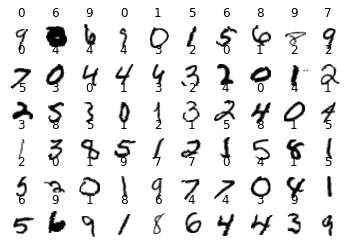

In [13]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.title(str(labels[index].item()))
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

### Create a Model
- will create like 5-7 layers of networks
- not use padding
- channels to be a minimal in number
- create multiple sequential blocks
- 28X28 > 26X26 > 24X24 > 22X22 > MP (11X11) > 9X9 > 7X7 > 1X1

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3), padding = 0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU()
            
        )
        
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), padding = 0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
            
        )
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3,3), padding = 0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
            
        )
        self.pool1 = nn.MaxPool2d(2,2)
        

        #create a transition 
        
        
        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=20, kernel_size=(3,3), padding = 0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        )
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1,1), padding = 0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        )
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3,3), padding = 0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        )
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(3,3), padding = 0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        )
        
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1

        self.dropout = nn.Dropout(0.1)
        
        
    def forward(self,x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock7(x)
        
        x = self.convblock5(x)
        x = self.dropout(x)
        x = self.convblock6(x)
        x = self.gap(x)
        
        x = x.view(-1, 10)
        return F.log_softmax(x,dim=-1)
            

### Visualize the model

In [15]:

from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           1,152
       BatchNorm2d-5           [-1, 16, 24, 24]              32
              ReLU-6           [-1, 16, 24, 24]               0
            Conv2d-7           [-1, 20, 22, 22]           2,880
       BatchNorm2d-8           [-1, 20, 22, 22]              40
              ReLU-9           [-1, 20, 22, 22]               0
          Dropout-10           [-1, 20, 22, 22]               0
        MaxPool2d-11           [-1, 20, 11, 11]               0
           Conv2d-12             [-1, 20, 9, 9]           3,600
      BatchNorm2d-13             [-1, 20, 9, 9]              40
             ReLU-14             [-

### Training the Model

In [16]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        y_pred = model(data)
        
        loss = F.nll_loss(y_pred, target)
 
        train_losses.append(loss)
        
        loss.backward() #backward prop
        optimizer.step()
        
        pred = y_pred.argmax(dim=1, keepdim=True)
        
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        
        pbar.set_description(desc=f'Loss = {loss.item()} Batch_id = {batch_idx}\
            Accuracy={100*correct/processed:0.2f}')
        
        
        train_acc.append(100*correct/processed)

        
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
            
        
        

In [17]:
len(test_loader.dataset)

10000

In [18]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=1, momentum=0.9)
# scheduler = ExponentialLR(optimizer, gamma=0.9)
scheduler = StepLR(optimizer, step_size=60, gamma=0.1)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()


EPOCH: 0


Loss = 0.13578981161117554 Batch_id = 468            Accuracy=94.70: 100%|██████████| 469/469 [00:56<00:00,  8.31it/s]



Test set: Average loss: 0.1240, Accuracy: 9596/10000 (95.96%)

EPOCH: 1


Loss = 0.09374283999204636 Batch_id = 468            Accuracy=97.92: 100%|██████████| 469/469 [00:51<00:00,  9.15it/s]



Test set: Average loss: 0.0458, Accuracy: 9853/10000 (98.53%)

EPOCH: 2


Loss = 0.13087372481822968 Batch_id = 468            Accuracy=98.47: 100%|██████████| 469/469 [00:50<00:00,  9.27it/s]



Test set: Average loss: 0.0472, Accuracy: 9855/10000 (98.55%)

EPOCH: 3


Loss = 0.056673020124435425 Batch_id = 468            Accuracy=98.55: 100%|██████████| 469/469 [00:51<00:00,  9.09it/s]



Test set: Average loss: 0.0340, Accuracy: 9897/10000 (98.97%)

EPOCH: 4


Loss = 0.06815196573734283 Batch_id = 468            Accuracy=98.69: 100%|██████████| 469/469 [00:50<00:00,  9.28it/s]



Test set: Average loss: 0.0331, Accuracy: 9902/10000 (99.02%)

EPOCH: 5


Loss = 0.003116604872047901 Batch_id = 468            Accuracy=98.82: 100%|██████████| 469/469 [00:50<00:00,  9.23it/s]



Test set: Average loss: 0.0419, Accuracy: 9867/10000 (98.67%)

EPOCH: 6


Loss = 0.0657932385802269 Batch_id = 468            Accuracy=98.91: 100%|██████████| 469/469 [00:51<00:00,  9.04it/s]



Test set: Average loss: 0.0318, Accuracy: 9897/10000 (98.97%)

EPOCH: 7


Loss = 0.0388023816049099 Batch_id = 468            Accuracy=98.97: 100%|██████████| 469/469 [00:54<00:00,  8.67it/s]



Test set: Average loss: 0.0313, Accuracy: 9912/10000 (99.12%)

EPOCH: 8


Loss = 0.0034053651615977287 Batch_id = 468            Accuracy=98.94: 100%|██████████| 469/469 [00:54<00:00,  8.66it/s]



Test set: Average loss: 0.0235, Accuracy: 9925/10000 (99.25%)

EPOCH: 9


Loss = 0.0058442396111786366 Batch_id = 468            Accuracy=99.06: 100%|██████████| 469/469 [00:54<00:00,  8.60it/s]



Test set: Average loss: 0.0277, Accuracy: 9920/10000 (99.20%)

EPOCH: 10


Loss = 0.020034031942486763 Batch_id = 468            Accuracy=99.05: 100%|██████████| 469/469 [00:53<00:00,  8.79it/s]



Test set: Average loss: 0.0265, Accuracy: 9910/10000 (99.10%)

EPOCH: 11


Loss = 0.04367446526885033 Batch_id = 468            Accuracy=99.12: 100%|██████████| 469/469 [00:53<00:00,  8.72it/s]



Test set: Average loss: 0.0260, Accuracy: 9924/10000 (99.24%)

EPOCH: 12


Loss = 0.03683888167142868 Batch_id = 468            Accuracy=99.17: 100%|██████████| 469/469 [00:54<00:00,  8.57it/s]



Test set: Average loss: 0.0223, Accuracy: 9925/10000 (99.25%)

EPOCH: 13


Loss = 0.02740011364221573 Batch_id = 468            Accuracy=99.18: 100%|██████████| 469/469 [00:53<00:00,  8.71it/s]



Test set: Average loss: 0.0223, Accuracy: 9922/10000 (99.22%)

EPOCH: 14


Loss = 0.002454170025885105 Batch_id = 468            Accuracy=99.21: 100%|██████████| 469/469 [00:53<00:00,  8.75it/s]



Test set: Average loss: 0.0246, Accuracy: 9925/10000 (99.25%)

